In [2]:
# Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.transform import resize
import os
from PIL import Image

In [5]:
# Directories

In [6]:
# Normalize and convert to tensors

In [7]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [8]:
# Load CIFAR-10 Dataset

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [05:16<00:00, 538kB/s]


In [10]:
# Visualize some clean images

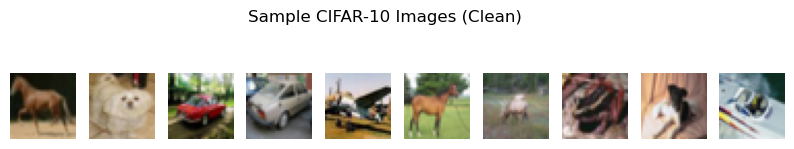

In [11]:
plt.figure(figsize=(10,2))
for i, (img, _) in enumerate(train_loader):
    if i == 1: break
    for j in range(10):
        plt.subplot(1,10,j+1)
        plt.imshow(np.transpose(img[j].numpy(), (1,2,0)))
        plt.axis('off')
plt.suptitle("Sample CIFAR-10 Images (Clean)")
plt.show()

In [20]:
# Preprocessing

In [22]:
# Downsample to half resolution to create low-res inputs

In [24]:
def downsample(batch, scale=2):
    batch_lr = np.zeros((batch.shape[0], batch.shape[1], batch.shape[2]//scale, batch.shape[3]//scale))
    for i in range(batch.shape[0]):
        img = np.transpose(batch[i].numpy(), (1,2,0))
        img_lr = resize(img, (img.shape[0]//scale, img.shape[1]//scale, img.shape[2]), anti_aliasing=True)
        batch_lr[i] = np.transpose(img_lr, (2,0,1))
    return torch.tensor(batch_lr, dtype=torch.float32)

In [26]:
# Example: visualize low-res vs high-res

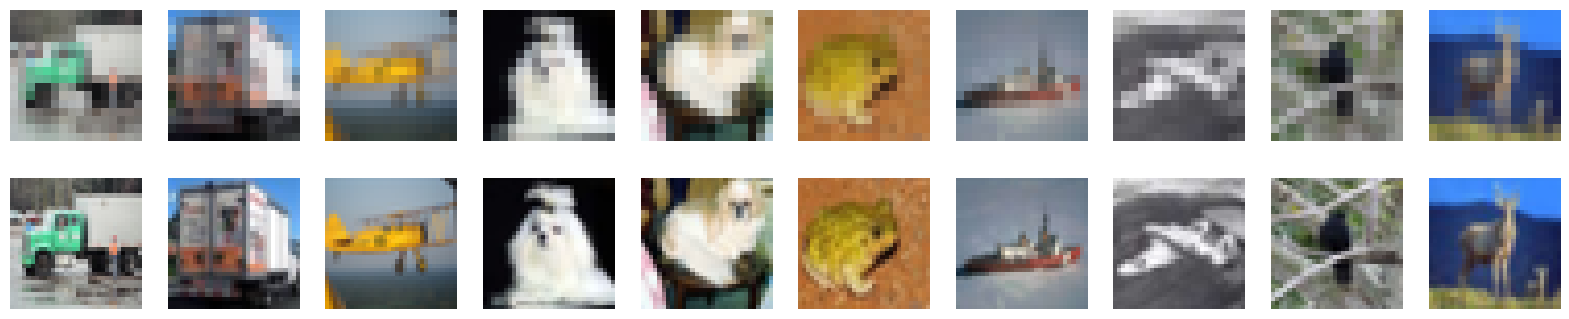

In [28]:
data_iter = iter(train_loader)
images, _ = next(data_iter)
images_lr = downsample(images, 2)
plt.figure(figsize=(20,4))
for i in range(10):
    # Low-res
    ax = plt.subplot(2,10,i+1)
    plt.imshow(np.transpose(images_lr[i].numpy(), (1,2,0)))
    plt.axis('off')
    if i==0: plt.ylabel("Low-Res")
    # High-res
    ax = plt.subplot(2,10,i+11)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)))
    plt.axis('off')
    if i==0: plt.ylabel("High-Res")
plt.show()

In [30]:
# Define Generator (SR Network)

In [32]:
# Lightweight residual CNN blocks

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out + identity

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3,64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(4)])
        self.conv2 = nn.Conv2d(64,64, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.upsample = nn.Sequential(
            nn.Conv2d(64,256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Conv2d(64,3, kernel_size=9, padding=4)
    def forward(self,x):
        out1 = self.relu(self.conv1(x))
        out = self.res_blocks(out1)
        out = self.bn(self.conv2(out)) + out1
        out = self.upsample(out)
        out = self.conv3(out)
        return torch.sigmoid(out)

generator = Generator()
print(generator)

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (con

In [36]:
# Define Discriminator

In [38]:
# Small CNN classifier for SR vs real HR

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*8*8,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.main(x)

discriminator = Discriminator()
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=8192, out_features=1024, bias=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(

In [ ]:
# Losses & Optimizers

In [ ]:
# MSE + BCE for adversarial

In [ ]:
criterion_mse = nn.MSELoss()
criterion_bce = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [ ]:
# Training Loop (CPU-friendly)

In [ ]:
device = torch.device("cpu")
generator.to(device)
discriminator.to(device)

num_epochs = 5  
for epoch in range(num_epochs):
    for i, (hr_imgs, _) in enumerate(train_loader):
        hr_imgs = hr_imgs.to(device)
        lr_imgs = downsample(hr_imgs, 2).to(device)
        
        valid = torch.ones(hr_imgs.size(0),1).to(device)
        fake = torch.zeros(hr_imgs.size(0),1).to(device)
        
        # Train Generator
        optimizer_G.zero_grad()
        sr_imgs = generator(lr_imgs)
        g_loss = criterion_mse(sr_imgs, hr_imgs)
        g_loss.backward()
        optimizer_G.step()
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion_bce(discriminator(hr_imgs), valid)
        fake_loss = criterion_bce(discriminator(sr_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()

In [ ]:
    print(f"Epoch [{epoch+1}/{num_epochs}] | G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}")

In [ ]:
        # Visualize SR progress after each epoch

In [ ]:
    plt.figure(figsize=(12,4))
    for j in range(5):
        plt.subplot(2,5,j+1)
        plt.imshow(np.transpose(lr_imgs[j].detach().numpy(), (1,2,0)))
        plt.axis('off')
        if j==0: plt.ylabel("Low-Res")
        plt.subplot(2,5,j+6)
        plt.imshow(np.transpose(sr_imgs[j].detach().numpy(), (1,2,0)))
        plt.axis('off')
        if j==0: plt.ylabel("Super-Res")
    plt.show()